In [1]:
import sys
sys.path.append("../../dataprocessing")
import numpy as np
import os
import PIL
import PIL.Image
from PIL import ImageDraw
import tensorflow as tf
# import tensorflow_datasets as tfds
import pandas as pd
from tqdm import tqdm
import random
import data_process
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.spatial import distance

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
import datetime as dt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from xgboost import XGBRegressor

## 함수 정의

In [2]:
cd ../

c:\Users\jongm\Desktop\MINI\projects\Facial-Expression-Recognition\modeling


In [3]:
def cal_dist(data):
    landmark_matrixs, landmark_matrixs_df = [], []
    lp = [point[:-1] for point in data.columns if '-' in point]
    set_lp = sorted(set(lp), key = lambda x: lp.index(x))
    for idx, row in data.iterrows():
        temp_list = []
        len_x = row['right'] - row['left']
        len_y = row['bottom'] - row['top']
        for i in range(len(set_lp)):
            temp_list.append([(row[set_lp[i]+'x'] - row['left']) / len_x, (row[set_lp[i]+'y'] - row['top']) / len_y])
        temp = pd.DataFrame(distance.cdist(temp_list, temp_list, metric='euclidean'), index=set_lp, columns=set_lp)
        landmark_matrixs.append(temp)
        landmark_matrixs_df.append(temp.to_numpy()[np.triu_indices(len(set_lp), 1)])
    return landmark_matrixs, pd.DataFrame(landmark_matrixs_df)

In [4]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        # if data.columns[idx] == 'frame':
        #     continue
        if data.columns[idx][:-1] in target_landmark:
            # print(x,y)
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        else:
            cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [5]:
def show_diff(*args):
    data = args[0]
    window = args[1]
    erase_list = ['frame','left','top','right','bottom','time_diff']
    data3 = data[[point for point in data.columns if '-' in point] + erase_list]

    if len(args) == 3:
        idxs = args[2]
        i = 0
        for idx in idxs:
            if i == 0:
                data2 = data[[point for point in data.columns if str(idx) == point.split('-')[0]]]
            else:
                data2 = pd.concat([data2, data[[point for point in data.columns if str(idx) == point.split('-')[0]]]], axis=1)
            i += 1
        data2 = pd.concat([data2, data[erase_list]], axis=1)
        # print(data2.columns)
    else:
        data2 = data3.copy()

    # print(list(set(data.columns) - set(erase_list)))
    remain_list = sorted(list(set(data2.columns) - set(erase_list)))
    diff_df = pd.DataFrame(columns=list(range(len(data2))), index=list(set([c[:-1] for c in remain_list])))

    # print(data2, remain_list)    
    for row in range(0, len(remain_list), 2):
        init_point = [data2.iloc[0][remain_list[row]], data2.iloc[0][remain_list[row+1]]]
        # print(remain_list[col], remain_list[col+1])
        temp2 = 0.0
        # diff_df[remain_list[col][:-1]] = 0
        for col in range(len(data2)):    
            # print(init_point, data.loc[col][remain_list[row]], data.loc[col][remain_list[row+1]])    
            temp = distance.euclidean(init_point, [data2.loc[col][remain_list[row]], data2.loc[col][remain_list[row+1]]])
            temp2 += temp
            # for start in range(0,len(data.index), window):
            #     # print(max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col]), max(data.iloc[start:start+5][col]), min(data.iloc[start:start+5][col]))
            #     temp += max(data.iloc[start:start+5][col]) - min(data.iloc[start:start+5][col])
            diff_df.at[remain_list[row][:-1], col] = temp
        diff_df.at[remain_list[row][:-1], 'sum'] = temp2
        # print(remain_list[col] + ", "+ remain_list[col+1])
    return diff_df.sort_values('sum', ascending=False), data3

In [6]:
def make_flow_chart(data, diff_df, part, order, image_order, path):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize = (20,10))
    # sort = diff_df.iloc[:order]
    # print(diff_df)
    if type(order) == int:        
        diff_df = diff_df.drop(['sum'], axis=1)
        new_data = diff_df.iloc[:order]
    elif type(order) == list:
        diff_df = diff_df.drop(['class'], axis=1)
        new_data = diff_df[order]
        new_data = new_data.transpose()
    # print(new_data.index)
    # new_data = new_data[[point for point in new_data.columns if str(part) == point.split('-')[0]]]
    temp_plot = sns.lineplot(data = new_data.transpose(), markers=False, dashes=False)  
    # print(path+str(image_order) + '.0.jpg')
    show_img(data, path + str(image_order) + '.0.jpg', new_data)
    # ax[idx, col].set_title(str(idx) +" 번 클러스터")
    # if col==0:        
    #     ax[idx, col].set_ylabel(list(custom_sort.keys())[idx])
    #     ax[idx, col].yaxis.label.set_size(20)
    # ax[idx].set_ylabel(list(custom_sort.keys())[idx] + " group")
    # ax[idx].set_xticks(list(range(1,len(seq)+1)))        
    # for row in data.iterrows():
    #     ax[idx].text(row[0], int(row[1]['quiz']), int(row[1]['quiz']), fontsize=12, ha='center') 
    #     ax[idx].text(row[0], int(row[1]['proj']), int(row[1]['proj']), fontsize=12, ha='center')

In [7]:
def predict(data_path1, data_path2, model):
    landmarks = pd.read_csv(data_path1)
    landmarks2 = pd.read_csv(data_path2)
    landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
    landmark_matrixs_df['class'] = 0.0
    landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
    landmark_matrixs_df2['class'] = 1.0
    df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
    length_i = len(landmark_matrixs[0].columns)
    start = 1
    name_list = []
    for i in landmark_matrixs[0].index:
        for j in range(start, length_i):
            name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
        start += 1

    X = df.drop(['class'], axis=1)
    X = X.astype('float')
    y = df['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

    if model == 'rf':
        set_model = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)
    elif model == 'xgboost':
        set_model = XGBRegressor(use_label_encoder=False, eval_metric='mlogloss')

    set_model.fit(X_train, y_train)
    pred = set_model.predict(X_test)
    # print(confusion_matrix(y_test, pred))    
    print('훈련세트 정확도: {:.3f}' .format(set_model.score(X_train, y_train)))
    print('테스트세트 정확도: {:.3f}' .format(set_model.score(X_test, y_test)))
    importance = pd.DataFrame({'landmarks': name_list, 'importance': set_model.feature_importances_})
    importance = importance.sort_values('importance',ascending=False)
    importance = importance.astype({'landmarks':'str'})
    print(importance)
    return landmarks2, importance

In [8]:
def show_img(data, path, landmark_points):    
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # img = cv2.imread(path, cv2.IMREAD_COLOR)    
    drawing_image = img.copy()
    target_landmark = landmark_points.index
    # print(landmark_points.index)
    # print(data)
    for idx in range(0,len(data.columns),2):
        radius = 2
        x = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx]]
        y = data.loc[int(float(path.split('/')[4][:-4]))][data.columns[idx+1]]
        if data.columns[idx] == 'frame':
            continue
        cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius, color=(0,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # if data.columns[idx][:-1] in target_landmark:
        #     # print(x,y)
        #     cv2.circle(drawing_image, center= tuple([int(x),int(y)]), radius=radius*2, color=(255,255,0), thickness=-1, lineType=cv2.LINE_AA)
        # else:
    for point_pair in landmark_points:
        x1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'x']
        y1 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[0]+'y']
        x2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'x']
        y2 = data.loc[int(float(path.split('/')[4][:-4]))][point_pair[1]+'y']
        cv2.line(drawing_image, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), radius)
    # img_show(drawing_image)
    left = data.loc[int(float(path.split('/')[4][:-4]))]['left']
    top = data.loc[int(float(path.split('/')[4][:-4]))]['top']
    right = data.loc[int(float(path.split('/')[4][:-4]))]['right']
    bottom = data.loc[int(float(path.split('/')[4][:-4]))]['bottom']
    plt.subplots(figsize=(10,10))
    # cv2.rectangle(drawing_image, (int(left), int(top)), (int(right), int(bottom)), (255, 255, 0), 3)
    plt.imshow(cv2.cvtColor(drawing_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

> 0은 얼굴 테두리 \
> 1, 2는 왼쪽 눈썹 위, 아래 \
> 3, 4는 오른쪽 눈썹 위, 아래 \
> 5, 6은 왼쪽, 오른쪽 눈 \
> 7, 8은 위쪽 입술 윗부분, 아래부분 \
> 9, 10은 아래쪽 입술 윗부분, 아래부분 \
> 11은 코 세로축 \
> 12는 코 아래부분

## 1. 눈썹 들어올리기

In [22]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'rf')

훈련세트 정확도: 0.996
테스트세트 정확도: 0.990
        landmarks  importance
5151    3-1 ↔ 6-4        0.26
5068    3-0 ↔ 6-6        0.22
5483    4-0 ↔ 6-6        0.17
5067    3-0 ↔ 6-5        0.06
5150    3-1 ↔ 6-3        0.04
...           ...         ...
2921   0-24 ↔ 4-3        0.00
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


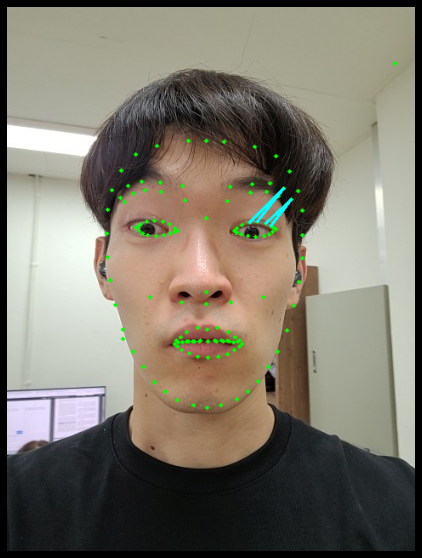

In [23]:
face = '눈썹들어올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [24]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/눈썹들어올리기+1/202209.06220402854.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
5068    3-0 ↔ 6-6         1.0
0       0-0 ↔ 0-1         0.0
5855    5-0 ↔ 5-4         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
2917   0-24 ↔ 3-4         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


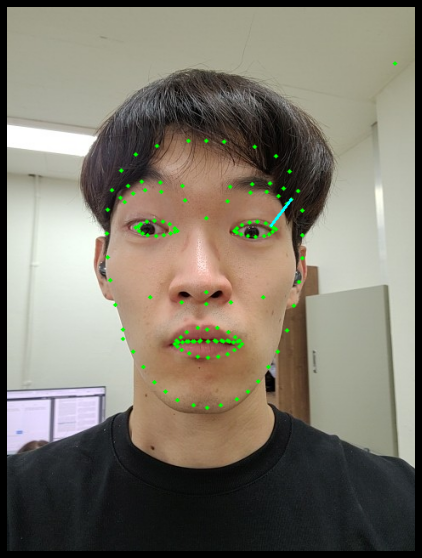

In [25]:
face = '눈썹들어올리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 3. 두 눈 감기

In [26]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'rf')

훈련세트 정확도: 0.973
테스트세트 정확도: 0.927
        landmarks  importance
564     0-4 ↔ 3-1    0.097273
5647   4-2 ↔ 6-11    0.087578
5646   4-2 ↔ 6-10    0.064576
8034   7-5 ↔ 12-2    0.053521
5806   4-4 ↔ 6-15    0.026916
...           ...         ...
2955   0-24 ↔ 7-0    0.000000
2954  0-24 ↔ 6-15    0.000000
2953  0-24 ↔ 6-14    0.000000
2952  0-24 ↔ 6-13    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


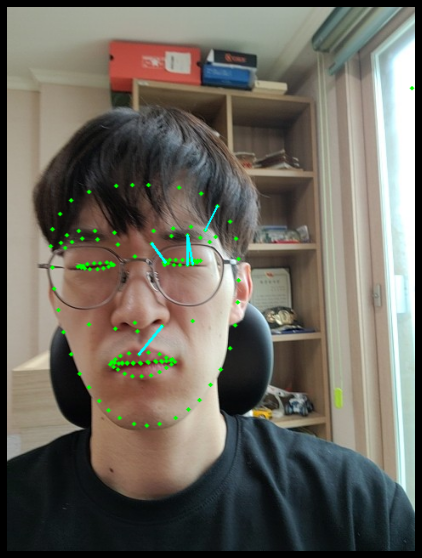

In [27]:
face = '두눈감기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [28]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈감기+1/202209.03105914019.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 0.900
        landmarks  importance
4343   1-2 ↔ 5-13    0.604751
1731   0-13 ↔ 8-8    0.110635
1981  0-15 ↔ 10-5    0.055602
27     0-0 ↔ 0-28    0.055399
5646   4-2 ↔ 6-10    0.038946
...           ...         ...
2945   0-24 ↔ 6-6    0.000000
2944   0-24 ↔ 6-5    0.000000
2943   0-24 ↔ 6-4    0.000000
2942   0-24 ↔ 6-3    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


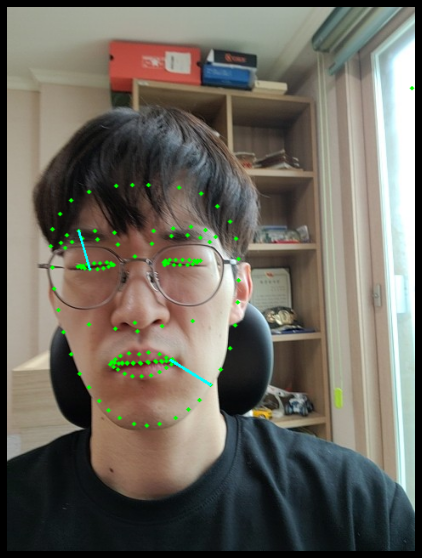

In [29]:
face = '두눈감기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:2]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 4. 두 눈 크게 뜨기

In [30]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'rf')

훈련세트 정확도: 0.989
테스트세트 정확도: 0.899
        landmarks  importance
6086   5-3 ↔ 5-13        0.41
6358   5-6 ↔ 12-0        0.12
6288   5-5 ↔ 12-0        0.10
6217   5-4 ↔ 12-0        0.03
6181    5-4 ↔ 7-4        0.03
...           ...         ...
2920   0-24 ↔ 4-2        0.00
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


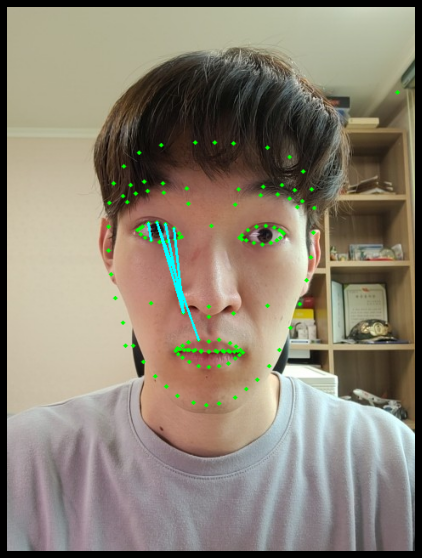

In [31]:
face = '두눈크게뜨기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [32]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/두눈크게뜨기+1/202209.03152411046.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 0.703
        landmarks  importance
6086   5-3 ↔ 5-13         1.0
5853    5-0 ↔ 5-2         0.0
5847   4-4 ↔ 12-0         0.0
5848   4-4 ↔ 12-1         0.0
5849   4-4 ↔ 12-2         0.0
...           ...         ...
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
2917   0-24 ↔ 3-4         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


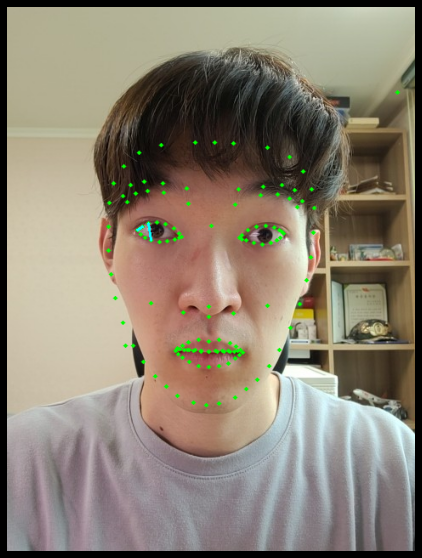

In [33]:
face = '두눈크게뜨기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:2]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 9. 입벌리기

In [34]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'rf')

훈련세트 정확도: 0.994
테스트세트 정확도: 1.000
        landmarks  importance
8378    8-5 ↔ 9-3        0.03
8242   8-0 ↔ 10-8        0.02
8585   9-4 ↔ 12-2        0.02
8438   8-7 ↔ 10-1        0.02
8088    7-7 ↔ 9-1        0.02
...           ...         ...
2925   0-24 ↔ 5-2        0.00
2924   0-24 ↔ 5-1        0.00
2923   0-24 ↔ 5-0        0.00
2922   0-24 ↔ 4-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


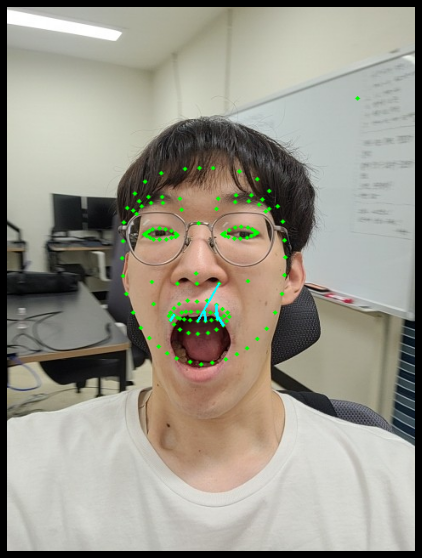

In [35]:
face = '입벌리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [36]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입벌리기+1/202209.05132412050.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
564     0-4 ↔ 3-1         1.0
0       0-0 ↔ 0-1         0.0
5847   4-4 ↔ 12-0         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


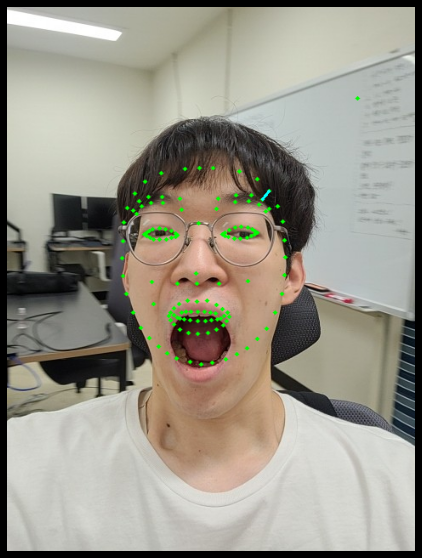

In [37]:
face = '입벌리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 입벌리기 비교

In [12]:
## cls
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_cls = RandomForestClassifier(bootstrap=True, random_state=2022, oob_score=True)

rf_cls.fit(X_train, y_train)
pred = rf_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
rf_cls.predict(landmark_matrixs_df_test)

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
8378    8-5 ↔ 9-3    0.030446
8134   7-8 ↔ 10-2    0.020000
8088    7-7 ↔ 9-1    0.020000
8696  10-2 ↔ 12-1    0.020000
8026   7-5 ↔ 10-5    0.020000
...           ...         ...
2928   0-24 ↔ 5-5    0.000000
2927   0-24 ↔ 5-4    0.000000
2926   0-24 ↔ 5-3    0.000000
2925   0-24 ↔ 5-2    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [9]:
## regressor
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_reg = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_reg.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_reg.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_reg.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
rf_reg.predict(landmark_matrixs_df_test)

훈련세트 정확도: 0.994
테스트세트 정확도: 1.000
        landmarks  importance
8378    8-5 ↔ 9-3        0.03
8242   8-0 ↔ 10-8        0.02
8585   9-4 ↔ 12-2        0.02
8438   8-7 ↔ 10-1        0.02
8088    7-7 ↔ 9-1        0.02
...           ...         ...
2925   0-24 ↔ 5-2        0.00
2924   0-24 ↔ 5-1        0.00
2923   0-24 ↔ 5-0        0.00
2922   0-24 ↔ 4-4        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


array([0.96, 0.96, 0.96, 0.95, 0.95, 0.92, 0.9 , 0.93, 0.92, 0.89, 0.91,
       0.92, 0.94, 0.95, 0.96, 0.94, 0.95, 0.94, 0.82])

In [13]:
from sklite import LazyExport
lazy = LazyExport(rf_cls)
lazy.save('rf_regression.json')

c:\Users\jongm\Anaconda3\envs\tfface\lib\site-packages\sklite\lib\abstract.py:85: UserWarning: C:\Users\jongm/.sklite has been created.
  warnings.warn(wrn)


In [14]:
## xgb_cls
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

xgb_cls = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xgb_cls.fit(X_train, y_train)
pred = xgb_cls.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(xgb_cls.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(xgb_cls.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': xgb_cls.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
xgb_cls.predict(landmark_matrixs_df_test)

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
564     0-4 ↔ 3-1         1.0
0       0-0 ↔ 0-1         0.0
5847   4-4 ↔ 12-0         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
## xgb_reg
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

xgb_reg = XGBRegressor(use_label_encoder=False, eval_metric='mlogloss')

xgb_reg.fit(X_train, y_train)
pred = xgb_reg.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(xgb_reg.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(xgb_reg.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': xgb_reg.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.5/202209.15190045957.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
print([format(x, '.8f') for x in xgb_reg.predict(landmark_matrixs_df_test)])

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
564     0-4 ↔ 3-1         1.0
0       0-0 ↔ 0-1         0.0
5847   4-4 ↔ 12-0         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]
['0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.00008702', '0.00008702', '0.99991685', '0.00008702', '0.00008702', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685', '0.99991685']


### 0.5 데이터도 넣어서 예측 진행

In [28]:
## regressor
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'
data_path3 = '../data/images/입벌리기+0.5/202209.15190045957.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmarks3 = pd.read_csv(data_path3)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
landmark_matrixs3, landmark_matrixs_df3 = cal_dist(landmarks3)
landmark_matrixs_df3['class'] = 0.5
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2, landmark_matrixs_df3], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_reg = RandomForestRegressor(bootstrap=True, random_state=2022, oob_score=True, n_estimators=8)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_reg.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_reg.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_reg.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.3/202209.15193419194.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
rf_reg.predict(landmark_matrixs_df_test)

c:\Users\jongm\Anaconda3\envs\tfface\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


훈련세트 정확도: 0.983
테스트세트 정확도: 0.997
        landmarks  importance
8265    8-1 ↔ 9-8    0.110306
8585   9-4 ↔ 12-2    0.108863
8361   8-4 ↔ 10-5    0.108333
8088    7-7 ↔ 9-1    0.106884
726    0-5 ↔ 6-10    0.106558
...           ...         ...
2921   0-24 ↔ 4-3    0.000000
2920   0-24 ↔ 4-2    0.000000
2919   0-24 ↔ 4-1    0.000000
2918   0-24 ↔ 4-0    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


array([0.3125, 0.375 , 0.4375, 0.3125, 0.375 , 0.375 , 0.375 , 0.375 ,
       0.4375, 0.375 , 0.4375, 0.4375, 0.375 , 0.4375, 0.5   , 0.3125,
       0.4375, 0.5   , 0.5   , 0.3125])

In [27]:
## regressor
data_path1 = '../data/images/중립/202209.03105902855.csv'
data_path2 = '../data/images/입벌리기+1/202209.05132412050.csv'
data_path3 = '../data/images/입벌리기+0.5/202209.15190045957.csv'

landmarks = pd.read_csv(data_path1)
landmarks2 = pd.read_csv(data_path2)
landmarks3 = pd.read_csv(data_path3)
landmark_matrixs, landmark_matrixs_df = cal_dist(landmarks)
landmark_matrixs_df['class'] = 0.0
landmark_matrixs2, landmark_matrixs_df2 = cal_dist(landmarks2)
landmark_matrixs_df2['class'] = 1.0
landmark_matrixs3, landmark_matrixs_df3 = cal_dist(landmarks3)
landmark_matrixs_df3['class'] = 0.5
df = pd.concat([landmark_matrixs_df, landmark_matrixs_df2, landmark_matrixs_df3], axis=0)
length_i = len(landmark_matrixs[0].columns)
start = 1
name_list = []
for i in landmark_matrixs[0].index:
    for j in range(start, length_i):
        name_list.append(str(i)+' ↔ '+str(landmark_matrixs[0].columns[j]))
    start += 1

X = df.drop(['class'], axis=1)
X = X.astype('float')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

rf_reg = XGBRegressor(eval_metric='logloss', learning_rate=0.08, reg_lambda=1, n_estimators=500)

rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)
# print(confusion_matrix(y_test, pred))    
print('훈련세트 정확도: {:.3f}' .format(rf_reg.score(X_train, y_train)))
print('테스트세트 정확도: {:.3f}' .format(rf_reg.score(X_test, y_test)))
importance = pd.DataFrame({'landmarks': name_list, 'importance': rf_reg.feature_importances_})
importance = importance.sort_values('importance',ascending=False)
importance = importance.astype({'landmarks':'str'})
print(importance)
test_df = pd.read_csv('../data/images/입벌리기+0.3/202209.15193419194.csv')
landmark_matrixs_test, landmark_matrixs_df_test = cal_dist(test_df)
landmark_matrixs_df_test = landmark_matrixs_df_test.astype('float')
rf_reg.predict(landmark_matrixs_df_test)

훈련세트 정확도: 1.000
테스트세트 정확도: 0.843
        landmarks  importance
7867   7-1 ↔ 10-8    0.836338
1166   0-9 ↔ 0-24    0.163659
7919    7-3 ↔ 7-6    0.000002
725     0-5 ↔ 6-9    0.000001
5853    5-0 ↔ 5-2    0.000000
...           ...         ...
2921   0-24 ↔ 4-3    0.000000
2920   0-24 ↔ 4-2    0.000000
2919   0-24 ↔ 4-1    0.000000
2918   0-24 ↔ 4-0    0.000000
8777  13-0 ↔ 14-0    0.000000

[8778 rows x 2 columns]


array([0.50002307, 0.50002307, 0.50002307, 0.50002307, 0.50002307,
       0.50002307, 0.50002307, 0.50002307, 0.50002307, 0.50002307,
       0.5000005 , 0.50002307, 0.50002307, 0.50002307, 0.5000005 ,
       0.50002307, 0.50002307, 0.50002307, 0.50002307, 0.50002307],
      dtype=float32)

## 10. 입술 오므리기

In [38]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.07212003856.csv', 'rf')

훈련세트 정확도: 0.998
테스트세트 정확도: 0.996
        landmarks  importance
7906   7-2 ↔ 10-5        0.04
8361   8-4 ↔ 10-5        0.04
8026   7-5 ↔ 10-5        0.04
8302   8-2 ↔ 10-5        0.03
8388   8-5 ↔ 10-4        0.03
...           ...         ...
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
2916   0-24 ↔ 3-3        0.00
2915   0-24 ↔ 3-2        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


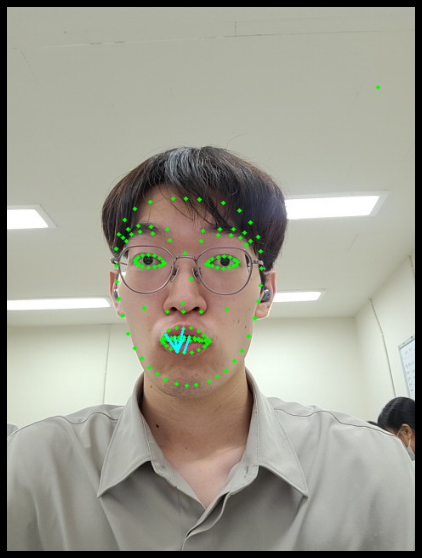

In [39]:
face = '입술오므리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 2
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [40]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/입술오므리기+1/202209.07212003856.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
3732   0-32 ↔ 1-1         1.0
0       0-0 ↔ 0-1         0.0
5855    5-0 ↔ 5-4         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
2917   0-24 ↔ 3-4         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


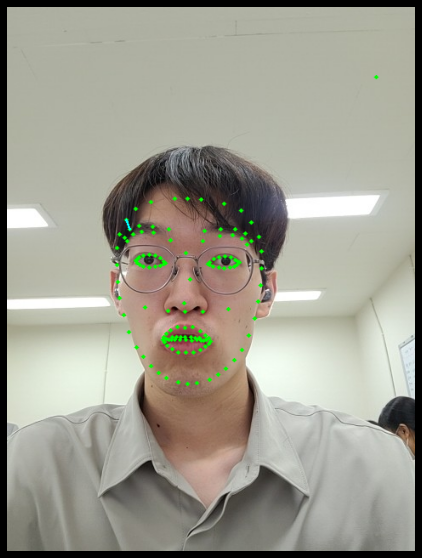

In [41]:
face = '입술오므리기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 3
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

## 16. 미소짓기

In [42]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'rf')

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
7995   7-4 ↔ 12-2        0.02
8247   8-0 ↔ 12-2        0.02
8680  10-1 ↔ 11-0        0.02
7687  6-13 ↔ 10-6        0.01
3716  0-31 ↔ 10-4        0.01
...           ...         ...
2919   0-24 ↔ 4-1        0.00
2918   0-24 ↔ 4-0        0.00
2917   0-24 ↔ 3-4        0.00
2916   0-24 ↔ 3-3        0.00
8777  13-0 ↔ 14-0        0.00

[8778 rows x 2 columns]


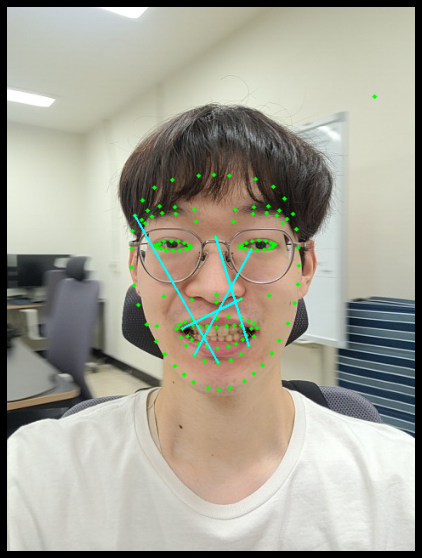

In [43]:
face = '미소짓기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:5]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)

In [44]:
landmarks, importance = predict('../data/images/중립/202209.03105902855.csv', '../data/images/미소짓기+1/202209.05132448886.csv', 'xgboost')

훈련세트 정확도: 1.000
테스트세트 정확도: 1.000
        landmarks  importance
867     0-6 ↔ 7-9         1.0
0       0-0 ↔ 0-1         0.0
5848   4-4 ↔ 12-1         0.0
5849   4-4 ↔ 12-2         0.0
5850   4-4 ↔ 13-0         0.0
...           ...         ...
2921   0-24 ↔ 4-3         0.0
2920   0-24 ↔ 4-2         0.0
2919   0-24 ↔ 4-1         0.0
2918   0-24 ↔ 4-0         0.0
8777  13-0 ↔ 14-0         0.0

[8778 rows x 2 columns]


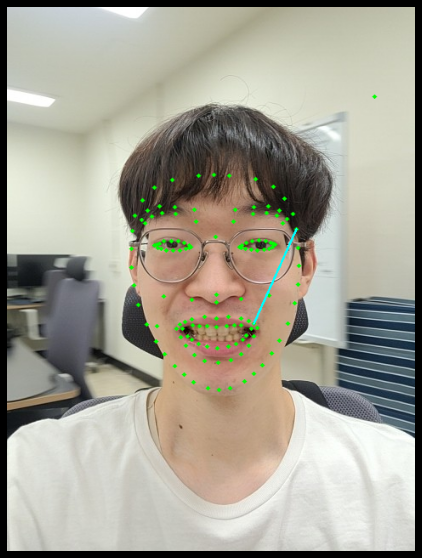

In [45]:
face = '미소짓기+1'
diff_list, landmarks_cut = show_diff(landmarks, 5)
diff_list = [x.split(' ↔ ') for x in importance.iloc[:1]['landmarks']]
image_order = 15
show_img(landmarks_cut, '../data/images/'+face+'/' + str(image_order) + '.0.jpg', diff_list)